# Importance Sampling

I will compute the area of a p-norm ball in 2D, where p = 0.5 by using importance sampling. I will also report the variance of my estimate for N = 1000 samples.

In previous assignment, we used rejection sampling to generate uniform p-norm ball samples. We compensated for the fact that we sampled from the distribution $g(x)$ instead of $f(x)$ by rejecting some of the values proposed by $f(x)$. In importance sampling, we will use weights to correct for the fact that we sample from another distribution. It is based on the identity:

$$P(X \in A) = \int_{A} f(x) dx = \int_{A} g(x) \frac{f(x)}{g(x)} dx = \int_{A} g(x) w(x) dx$$

I also used rotated unit square as g(x) for sampling and rejection, to increase the efficiency of rejection sampling when trying to generate uniform samples from a p-norm ball.

In this example, it is multivariate so I can use multivariate gaussian distribution as proposal. I am going to choose a mean and covariance matrix and generate $(x,y)$ samples, then if they satisfy the condition $|x|^p + |y|^p \leq 1$, I will normalize them (or use weights). Then I can find the area of the 0.5 norm ball.

Let's first generate multivariate normal numbers randomly.

In [102]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 2000
mean = np.array([0, 0])
cov = np.array([[0.1, 0], [0, 0.1]])
x, y = np.random.multivariate_normal(mean, cov, N).T

According to Wikipedia, density function of multivariate normal distribution for non-degenerate case (covariance matrix is positive definite), is as follows and I will use it as proposal.

$$f_{x}(x_{1},. . . , x_{k}) = \frac{1}{\sqrt{(2\pi)^{k}|\Sigma|}}\exp\left(-\frac{1}{2}(x - \mu)^{T}\Sigma^{-1}(x-\mu)\right)$$

where x is a real k-dimensional column vector (in our case, 2-dimensional and |$\Sigma$| is the determinant of $\Sigma$.

In [80]:
def density_function(x, mean, cov):
    k = len(x)
    det = np.linalg.det(cov)
    left_part = 1/(np.sqrt(np.power(2*np.pi, k) * det))
    exp_part = -1/2*(np.dot(np.dot(np.transpose(x-mean), np.linalg.inv(cov)), (x-mean)))
    return left_part * np.exp(exp_part)

We also need to calculate p-norm and if a vector satisfies the condition:

In [81]:
def filter_pnorm(x, y, p):
    return np.power(np.abs(x), p) + np.power(np.abs(y), p) <= 1

Now we can use these to calculate weighted samples.

In [82]:
def apply_weights(x, y, p):
    if filter_pnorm(x,y,p):
        return 1.0 / density_function(np.array([x, y]), mean, cov)
    else:
        return 0

Lastly, it is time to combine all these. We can do it for 25 times to have a estimate variance for N = 1000 samples.

In [83]:
def estimate_area(p):
    mean_estimates = []
    samples = []
    n = 30
    for i in range(n):
        for j in range(N):
            sample = apply_weights(x[j], y[j], p)
            samples.append(sample)
        mean_estimates.append(np.mean(samples))
        samples = []
    return mean_estimates

In [84]:
mean_estimates = estimate_area(0.5)
mean_estimate = np.mean(mean_estimates)
estimate_variance = np.var(mean_estimates)

print(mean_estimate)
print(estimate_variance)

0.677666696937
4.93038065763e-32


Area estimate is around 2/3 and variance is really small, though I am not sure about the reason. Just for fun, I want to try this area estimation experiment with p = {0.5, 0.6, 0.7, 0.8, 0.9, 1, 2}. Though it takes some time because, well, it is Python :)

In [85]:
ps = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]

for p in ps:
    area_estimate = estimate_area(p)
    mean_estimate = np.mean(area_estimate)
    estimate_variance = np.var(area_estimate)
    print("For p =", str(p), ", mean estimate =", mean_estimate, "and variance =", estimate_variance)

For p = 0.5 , mean estimate = 0.677666696937 and variance = 4.93038065763e-32
For p = 0.6 , mean estimate = 0.992781476518 and variance = 1.10933564797e-31
For p = 0.7 , mean estimate = 1.25141675526 and variance = 4.93038065763e-32
For p = 0.8 , mean estimate = 1.48616157686 and variance = 1.97215226305e-31
For p = 0.9 , mean estimate = 1.66144316086 and variance = 4.93038065763e-32
For p = 1 , mean estimate = 1.89065644407 and variance = 4.43734259187e-31
For p = 2 , mean estimate = 3.09955004722 and variance = 1.77493703675e-30


For a square with side length $\sqrt{2}$ the area estimate is 2.06, which is okay. For a unit circle the area estimate is 3.38, which is still okay but a bit far from $\pi$.

# Markov Chain

#### Transition Matrix

In [86]:
A = np.array([[0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
                [0, 0.25, 0, 0, 0.25, 0],
                [0, 0, 0, 0.50, 0, 0],
                [0.25, 0.25, 0.50, 0, 0.25, 0.25],
                [0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
                [0.25, 0, 0, 0, 0, 0.25]])

#### Stationary Distribution

The stationary distribution of a Markov Chain with transition matrix P is some vector v, such that vP = v. In other words, over the long run, no matter what the starting state was, the proportion of time the chain spends in state *j* is approximately $v_j$ for all *j*.

In [87]:
es, vs = np.linalg.eig(A)
i = np.argmax(np.isclose(es, 1.0))
v = vs[:, i]
v = np.real(v / sum(v))
print(v)

[ 0.25        0.08333333  0.11111111  0.22222222  0.25        0.08333333]


We can see that this stationary distribution is not uniform. A Markov Chain will spend more time in states 1 and 5.

#### Detailed Balance Condition

For detailed balance condition, I was looking for some explanations and I came across a really cool <a href="http://qr.ae/Rcfk8p">example</a>, so I wanted to share it. The code is from the PS.

In [88]:
x = np.real(np.dot(A, np.diag(v)))
print(x)

[[ 0.0625      0.02083333  0.02777778  0.05555556  0.0625      0.02083333]
 [ 0.          0.02083333  0.          0.          0.0625      0.        ]
 [ 0.          0.          0.          0.11111111  0.          0.        ]
 [ 0.0625      0.02083333  0.05555556  0.          0.0625      0.02083333]
 [ 0.0625      0.02083333  0.02777778  0.05555556  0.0625      0.02083333]
 [ 0.0625      0.          0.          0.          0.          0.02083333]]


In [89]:
print(np.isclose(x, x.T).all())

False


This transition matrix does not satisfy the detailed balance condition because for example, when the state is 3, it goes to 1 with p=0.25 probability but reverse path does not exist.

#### Finding Tmix

In [90]:
epsilon = 1e-8
stationary_vector = v
t_mix = 0
current_state = np.array([1, 0, 0, 0, 0, 0])

def variation_distance(x, y):
    return 0.5 * np.sum(np.abs(x-y))

distance = variation_distance(v, current_state)

while distance > epsilon:
    current_state = np.dot(A, current_state)
    distance = variation_distance(v, current_state)
    t_mix = t_mix + 1
    
print("T_mix is: " + str(t_mix))

T_mix is: 24


#### Visualization of Intermediary Powers of Transition Matrix

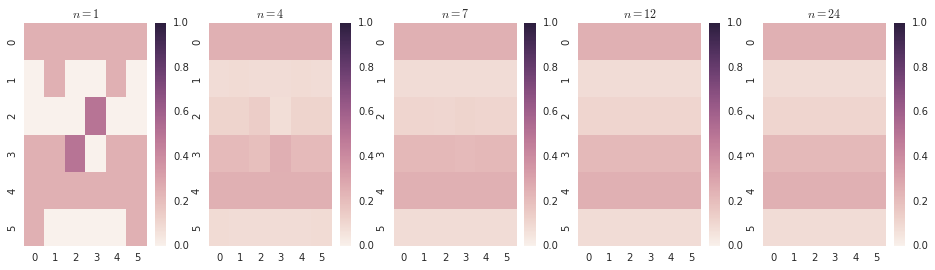

In [91]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 4))
for i, n in enumerate([1, 4, 7, 12, 24]):
    sns.heatmap(np.linalg.matrix_power(A, n), vmin = 0, vmax = 1, ax = ax[i])
    ax[i].set_title("$n = %d$" % n)
plt.show()

Verification of mixing time:

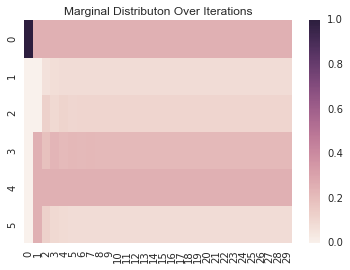

In [92]:
n = 30
states = np.zeros([6, n])
states[:, 0] = np.array([1,0,0,0,0,0])
for i in range(1,n):
    states[:,i] = np.dot(A, states[:, i-1])
    
sns.heatmap(states,vmin=0,vmax=1);
plt.title("Marginal Distributon Over Iterations");

#### Independent Samples

Firstly, let's define the simulation method for a single chain.

In [93]:
def simulate(P, N):
    chain = np.zeros(N).astype(int)
    chain[0] = 0
    for i in range(1,N):
        pr = P[:, chain[i-1]]
        chain[i] = np.random.choice(range(6), p = pr)

    return chain

Then we can run multiple chains and obtain independent samples.

Distribution at t=T_mix + 10: [ 0.238  0.082  0.103  0.241  0.246  0.09 ]


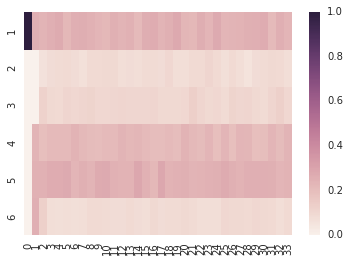

In [94]:
nchains = 1000
chain_length = t_mix + 10
samples = np.zeros([nchains, chain_length]).astype(int)
for i in range(0, nchains):
    ch = simulate(A, chain_length)
    samples[i,:] = ch
    
column_histograms = np.apply_along_axis(lambda x: np.histogram(x, bins = [0,1,2,3,4,5,6], density = True)[0], 0, samples)
sns.heatmap(column_histograms, yticklabels=range(1,7))
print('Distribution at t=T_mix + 10:',column_histograms[:,-1])

 #### Single Chain
 
 We can show chain after $T_{mix}$ steps and compare it to stationary distribution.

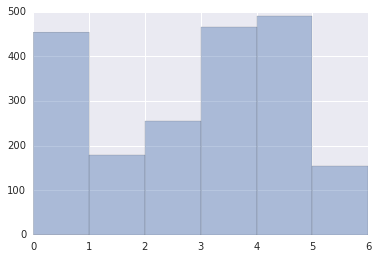

In [95]:
chain = simulate(A, t_mix+N)
nburnin = t_mix
sns.distplot(chain[nburnin:], kde = False, bins = [0,1,2,3,4,5,6])
plt.show()

Stationary distribution: [ 0.25        0.08333333  0.11111111  0.22222222  0.25        0.08333333]
Result: [ 0.227   0.0895  0.1275  0.233   0.2455  0.0775]


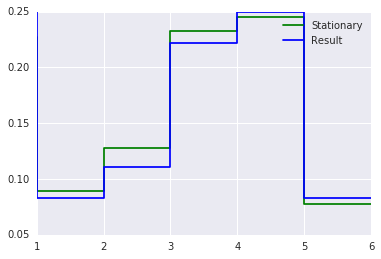

In [96]:
stationary_vector = np.real(stationary_vector)
result = np.bincount(chain[nburnin:].astype(int))
result = result / np.sum(result)
print("Stationary distribution:", stationary_vector)
print("Result:", result)

plt.step(np.array([1,2,3,4,5,6]), result, 'g', label = 'Stationary')
plt.step(np.array([1,2,3,4,5,6]), stationary_vector, 'b', label = 'Result')
plt.legend()
plt.show()